In [15]:
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns

import numpy as np
from datetime import datetime
import os

In [16]:
def plot_benchmarking_metrics(fig_title,
                              df,
                              y_col_name,
                              save_fig=False,
                              save_dir="../figures",
                              file_name="benchmarking_metrics.png"):
    fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
    fig.suptitle(fig_title)
    
    # Graph Connectivity Distance
    sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y=y_col_name)
    axes[0, 0].set_title("GCD")

    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y=y_col_name)
    axes[0, 1].set_title("MLNMI")

    # Cell-Type Affinity Distance
    sns.boxplot(data=df, ax=axes[1, 0], x="cad", y=y_col_name)
    axes[1, 0].set_title("CAD")

    # Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
    sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y=y_col_name)
    axes[1, 1].set_title("ARCLISI")

    # Cell Classification Accuracy
    sns.boxplot(data=df, ax=axes[2, 0], x="cca", y=y_col_name)
    axes[2, 0].set_title("CCA")

    # Gene Expression Regression Mean Squared Error
    sns.boxplot(data=df, ax=axes[2, 1], x="germse", y=y_col_name)
    axes[2, 1].set_title("GERMSE")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.5,
                        wspace=0.4,
                        hspace=0.4)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}_{current_timestamp}.png",
                    bbox_inches='tight')

In [28]:
def plot_eval_metrics(fig_title,
                      df,
                      y_col_name,
                      plot_ratio_active_gps=False,
                      save_fig=False,
                      save_dir="../figures",
                      file_name="benchmarking_metrics.png"):
    # Compute evaluation metric ranks and use total rank for sorting
    val_mse_score_ranks = (df.groupby([y_col_name])
                           ["val_mse_score"].mean().rank(ascending=True)
                           .rename("val_mse_score_rank"))
    val_auroc_score_ranks = (df.groupby([y_col_name])
                                ["val_auroc_score"].mean().rank(ascending=False)
                                .rename("val_auroc_score_rank"))
    df = df.merge(val_mse_score_ranks, on=[y_col_name])
    df = df.merge(val_auroc_score_ranks, on=[y_col_name])
    df["val_total_score_rank"] = (df["val_mse_score_rank"] + 
                                  df["val_auroc_score_rank"]).rank(ascending=True)

    df.sort_values(by=["val_total_score_rank", y_col_name],
                   inplace=True,
                   ascending=False)
    
    if plot_ratio_active_gps:
        fig, axes = plt.subplots(3, 1, sharey=True, figsize=(10, 20))
        
        # Ratio active gene programs
        sns.boxplot(data=df, ax=axes[2], x="ratio_active_gps", y=y_col_name)
        axes[2].set_title("Ratio of Active Gene Programs")
    else:
        fig, axes = plt.subplots(2, 1, sharey=True, figsize=(10, 15))
    fig.suptitle(fig_title, fontsize=15)
    
    # Edge reconstruction performance
    sns.boxplot(data=df, ax=axes[0], x="val_auroc_score", y=y_col_name)
    axes[0].set_title("Edge Reconstruction Area Under ROC Curve")

    # Gene expression reconstruction performance
    sns.boxplot(data=df, ax=axes[1], x="val_mse_score", y=y_col_name)
    axes[1].set_title("Gene Expression Reconstruction Mean Squared Error")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.94,
                        wspace=0.175,
                        hspace=0.175)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}",
                    bbox_inches='tight')


def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))

df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

def get_active_gp_group_lasso_comb(row):
    return f"active_gp_thresh_{row['active_gp_thresh_ratio_']}_+_group_lasso_{row['lambda_group_lasso_']}"

df["active_gp_group_lasso_comb"] = df.apply(lambda row: get_active_gp_group_lasso_comb(row), axis=1)

In [51]:
experiment_name = "benchmark_loss_weights"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

def get_loss_weights(row):  
    return f"lambda_edge_recon_{row['lambda_edge_recon_']}_+_lambda_gene_expr_recon_{row['lambda_gene_expr_recon_']}"
df["loss_weights"] = df.apply(lambda row: get_loss_weights(row), axis=1)

In [ ]:
2+3

In [52]:
df = df[df["avg_n_neighbors"] == "8.0"]

In [53]:
len(df)

0

In [21]:
len(df[(df["avg_n_neighbors"] == "4.0") & (df["conv_layer_encoder_"] == "gcnconv")])

0

In [111]:
df[["lambda_edge_recon_", "lambda_gene_expr_recon_", "encoder_n_attention_heads_", "conv_layer_encoder_", "avg_n_neighbors"]].head(20)

,lambda_edge_recon_,lambda_gene_expr_recon_,encoder_n_attention_heads_,conv_layer_encoder_,avg_n_neighbors
0,0.2,1.0,0,gcnconv,32.0
1,0.1,1.0,0,gcnconv,32.0
2,0.1,1.0,0,gcnconv,32.0
3,0,1.0,0,gcnconv,32.0
4,0,1.0,0,gcnconv,32.0


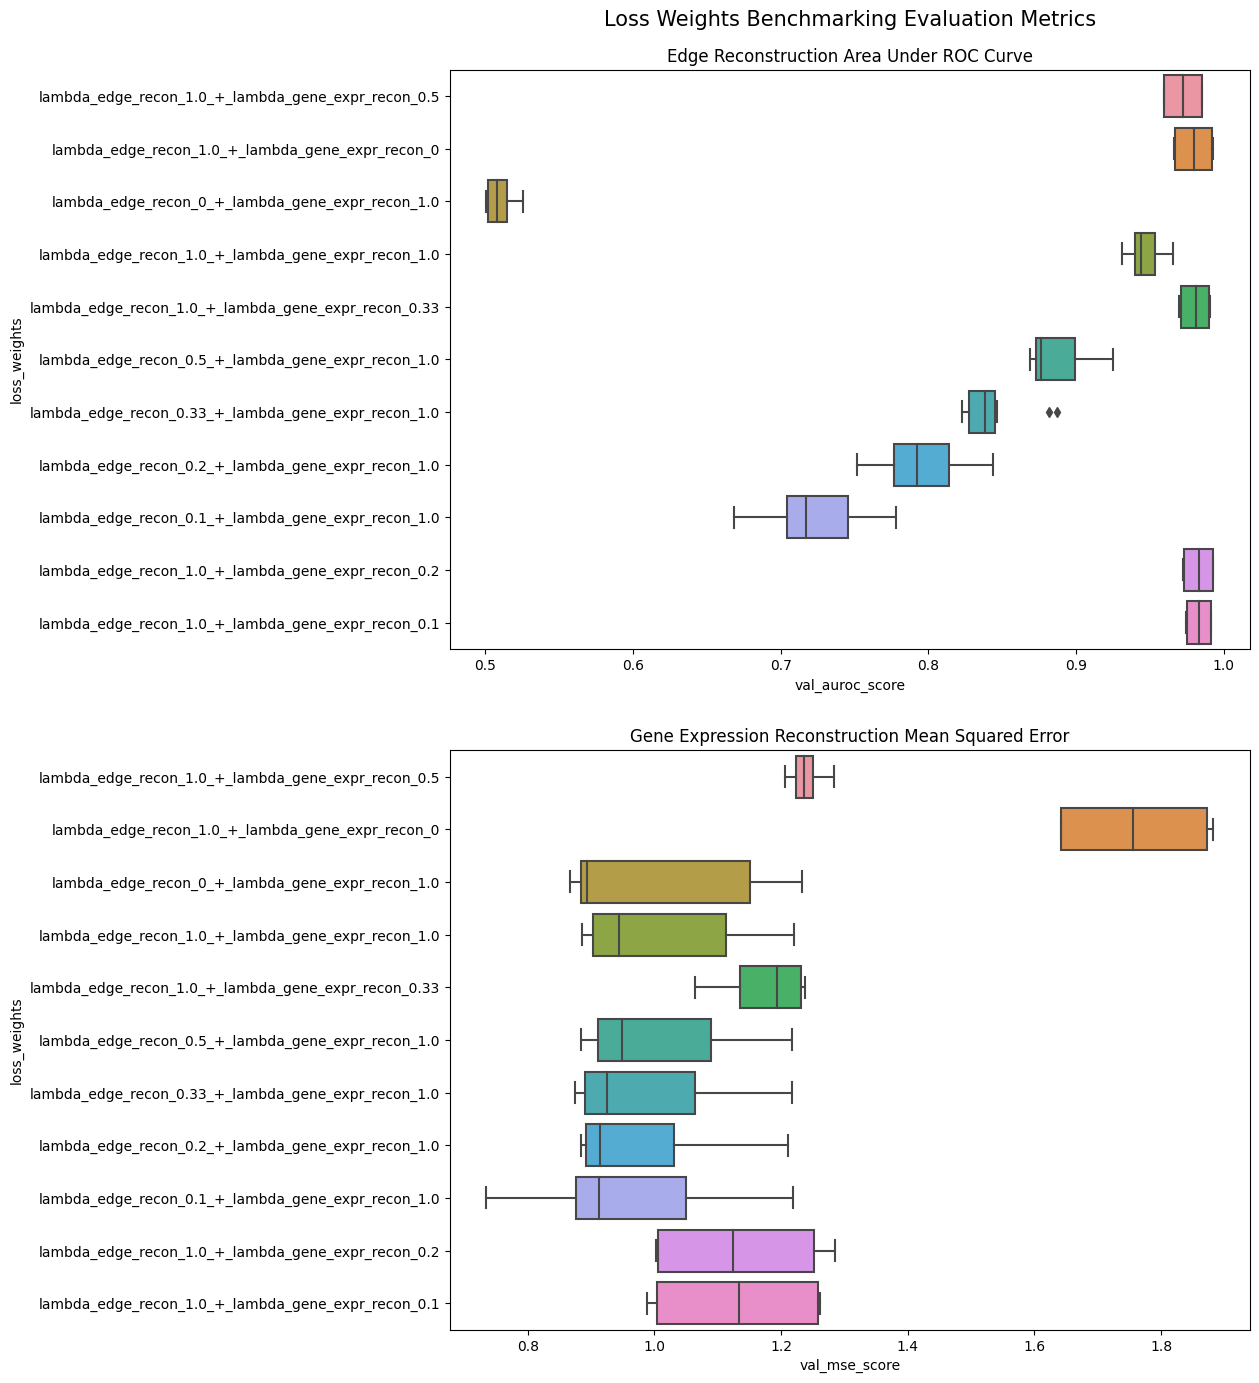

In [29]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="loss_weights",
                  plot_ratio_active_gps=False,
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=False)

In [16]:
df[df["lambda_gene_expr_recon_"] != '1.0'][["lambda_edge_recon_", "lambda_gene_expr_recon_", "encoder_n_attention_heads_", "conv_layer_encoder_"]]

,lambda_edge_recon_,lambda_gene_expr_recon_,encoder_n_attention_heads_,conv_layer_encoder_
20,1.0,0.5,8,gatv2conv
21,1.0,0.5,8,gatv2conv
22,1.0,0.33,8,gatv2conv
23,1.0,0.33,8,gatv2conv
24,1.0,0.2,8,gatv2conv
25,1.0,0.2,8,gatv2conv
26,1.0,0.1,8,gatv2conv
27,1.0,0.1,8,gatv2conv
28,1.0,0,8,gatv2conv
29,1.0,0,8,gatv2conv


In [17]:
df = df[df["lambda_group_lasso_"].astype(float) == 0]

In [33]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="loss_weights",
                  plot_ratio_active_gps=False,
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=False)

KeyError: 'Column not found: val_mse_score'

In [32]:
df[["lambda_edge_recon_", "lambda_gene_expr_recon_", "avg_n_neighbors"]]

,lambda_edge_recon_,lambda_gene_expr_recon_,avg_n_neighbors
0,1,1,4.0
1,1,1,4.0
2,1,1,4.0
3,1,1,4.0
4,1,1,4.0
5,1,1,4.0
6,1,1,4.0
7,1,1,4.0
8,1,1,4.0
117,1,0,4.0


In [13]:
experiment_name = "benchmark_active_gps"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [15]:
# Get active gene program ratio
def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))
df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

# Get combination of active gene program threshold and lambda group lasso
def get_active_gp_thresh_lambda_group_lasso(row):
    return f"active_gp_thresh_{row['active_gp_thresh_ratio_']}_+_lambda_group_lasso_{row['lambda_group_lasso_']}"
df["active_gp_thresh_lambda_group_lasso"] = df.apply(lambda row: get_active_gp_thresh_lambda_group_lasso(row), axis=1)

df = df[(df["lambda_edge_recon_"].astype(float) == 1.0) & 
        (df["lambda_gene_expr_recon_"].astype(float) == 1.0) &
        (df["n_active_gps"].notna())]

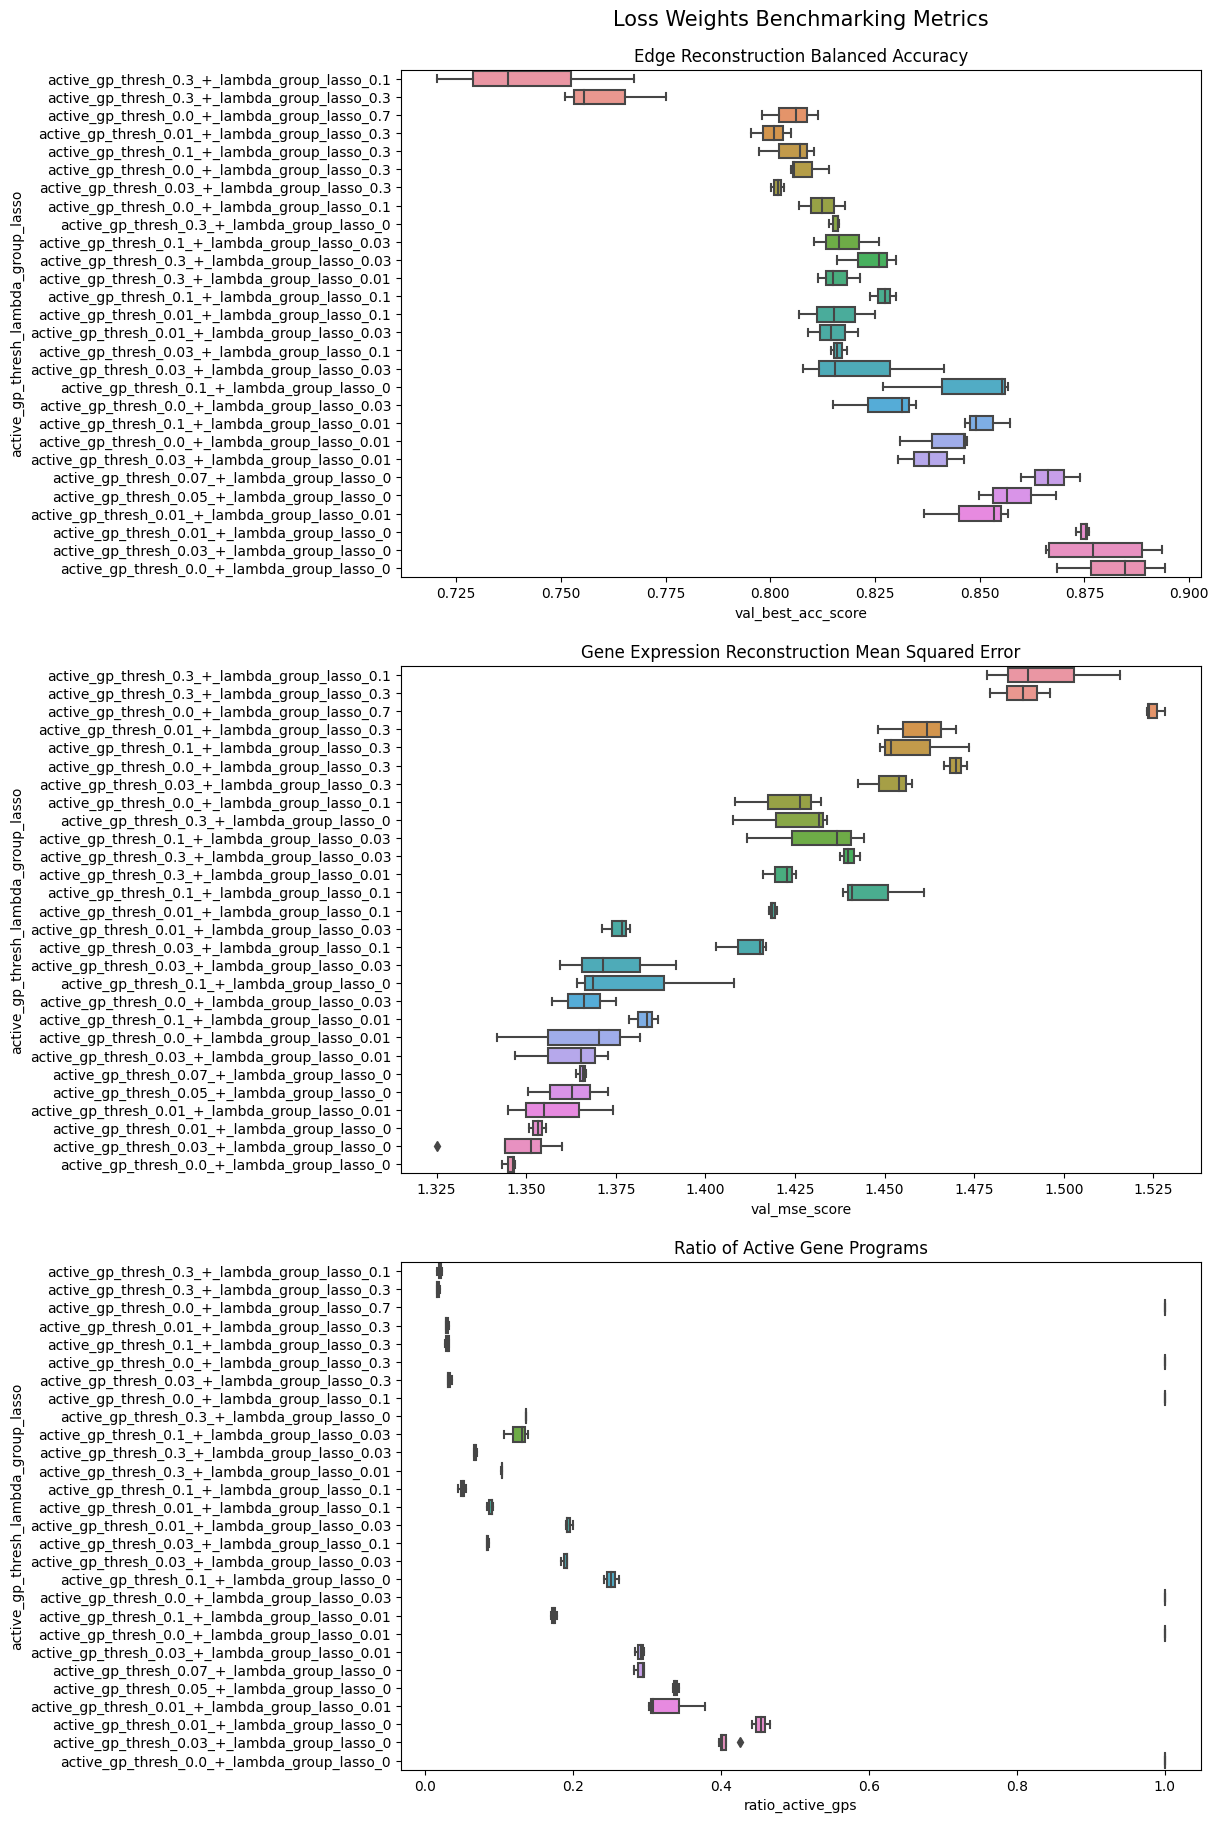

In [22]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="active_gp_thresh_lambda_group_lasso",
                  plot_ratio_active_gps=True,
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=False)

In [55]:
experiment_name = "benchmark_encoder_decoder_arch"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

Traceback (most recent call last):
  File "/root/miniconda3/envs/autotalker/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 800, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/root/miniconda3/envs/autotalker/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 632, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/root/miniconda3/envs/autotalker/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1049, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/root/miniconda3/envs/autotalker/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1042, in _read_helper
    result = read_yaml(root, file_name)
  File "/root/miniconda3/envs/autotalker/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % 

In [61]:
experiment_name = "benchmark_mixed"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [62]:
len(df)

56

In [63]:
df.sort_values(by="val_best_acc_score", ascending=False)[["val_best_acc_score", "val_mse_score", "lambda_edge_recon_", "gene_expr_recon_dist_", "node_label_method_", "conv_layer_encoder_", "encoder_n_attention_heads_"]]

,val_best_acc_score,val_mse_score,lambda_edge_recon_,gene_expr_recon_dist_,node_label_method_,conv_layer_encoder_,encoder_n_attention_heads_
25,0.902885,1.044338,1.0,nb,one-hop-attention,gatv2conv,1
17,0.900824,1.009295,2.0,nb,one-hop-attention,gatv2conv,8
36,0.897476,1.279623,3.0,nb,one-hop-norm,gatv2conv,8
37,0.895930,1.267828,2.0,nb,one-hop-norm,gatv2conv,8
16,0.893354,1.031737,3.0,nb,one-hop-attention,gatv2conv,8
35,0.892839,1.052758,1.0,nb,one-hop-attention,gcnconv,0
20,0.892066,0.974281,1.0,nb,one-hop-attention,gatv2conv,8
30,0.890778,1.052315,1.0,nb,one-hop-attention,gcnconv,0
55,0.890778,1.338817,1.0,nb,one-hop-norm,gcnconv,0
21,0.890520,1.075540,3.0,nb,one-hop-attention,gatv2conv,1


In [11]:
def get_encoder_decoder_arch(row):
    return f"encoder_layer_{row['conv_layer_encoder_']}_+_node_label_method_{row['node_label_method_']}_+_gene_expr_dist_{row['gene_expr_recon_dist_']}"

df["encoder_decoder_arch"] = df.apply(lambda row: get_encoder_decoder_arch(row), axis=1)

def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))

df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

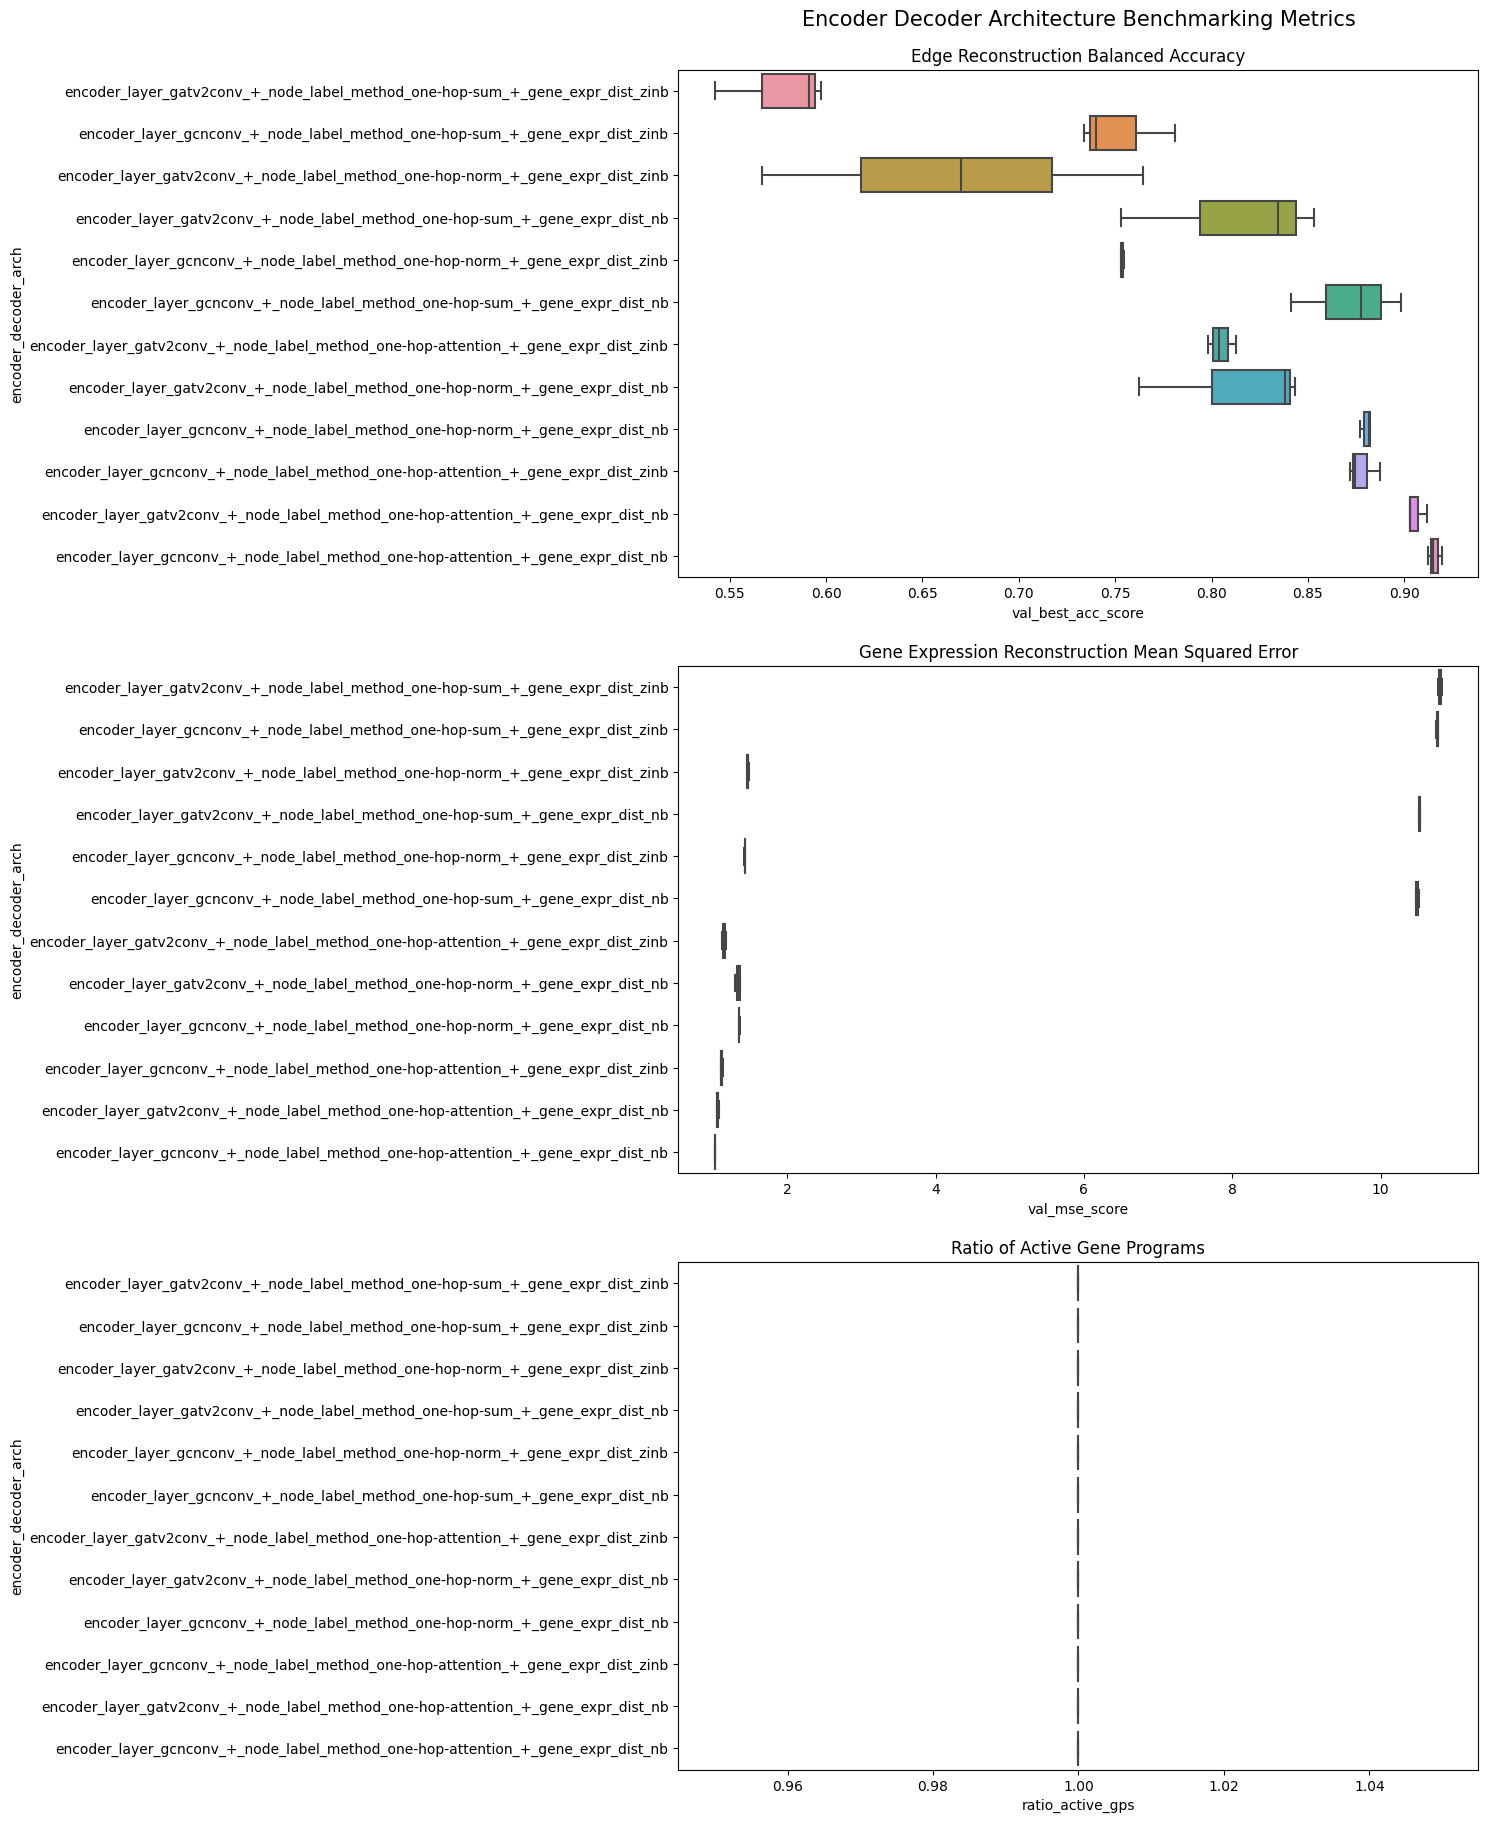

In [12]:
plot_eval_metrics(fig_title="Encoder Decoder Architecture Benchmarking Metrics",
                  df=df,
                  y_col_name="encoder_decoder_arch",
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_encoder_decoder_arch",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=True)

In [5]:
experiment_name = "benchmark_encoder_decoder_arch2"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [6]:
def get_conv_layer_encoder(row):
    return f"conv_layer_{row['conv_layer_encoder_']}_+_n_attention_heads_{row['encoder_n_attention_heads_']}"
df["conv_layer_encoder"] = df.apply(lambda row: get_conv_layer_encoder(row), axis=1)

def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))

df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

In [11]:
df_avg_n_neighbors_8 = df[df["avg_n_neighbors"].astype(float) == 8]
df_avg_n_neighbors_8 = df[df["avg_n_neighbors"].astype(float) == 4]

,lambda_edge_recon_,n_genes,gene_expr_recon_dist_,early_stopping_kwargs_,min_target_genes_per_gp,seed_,n_edges,monitor_,freeze_,node_train_ratio_,...,combine_overlap_gps,weight_decay_,val_auprc_score,n_active_gps,val_best_acc_score,val_best_f1_score,val_mse_score,val_auroc_score,conv_layer_encoder,ratio_active_gps
0,1,351,nb,{'early_stopping_metric': 'val_global_loss'},0,0,77668,True,False,0.9,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,conv_layer_gcnconv_+_n_attention_heads_0,NaN
1,1,351,nb,{'early_stopping_metric': 'val_global_loss'},0,0,77668,True,False,0.9,...,True,0.0,0.938126,489.0,0.904069,0.908718,0.8902,0.952672,conv_layer_gcnconv_+_n_attention_heads_0,1.0


In [10]:
df["avg_n_neighbors"]

0     8.0
1     8.0
2     4.0
3     4.0
4     4.0
5     4.0
6     4.0
7     4.0
8     4.0
9     4.0
10    4.0
11    4.0
12    4.0
13    4.0
14    4.0
15    4.0
16    4.0
17    4.0
18    4.0
19    4.0
Name: avg_n_neighbors, dtype: object

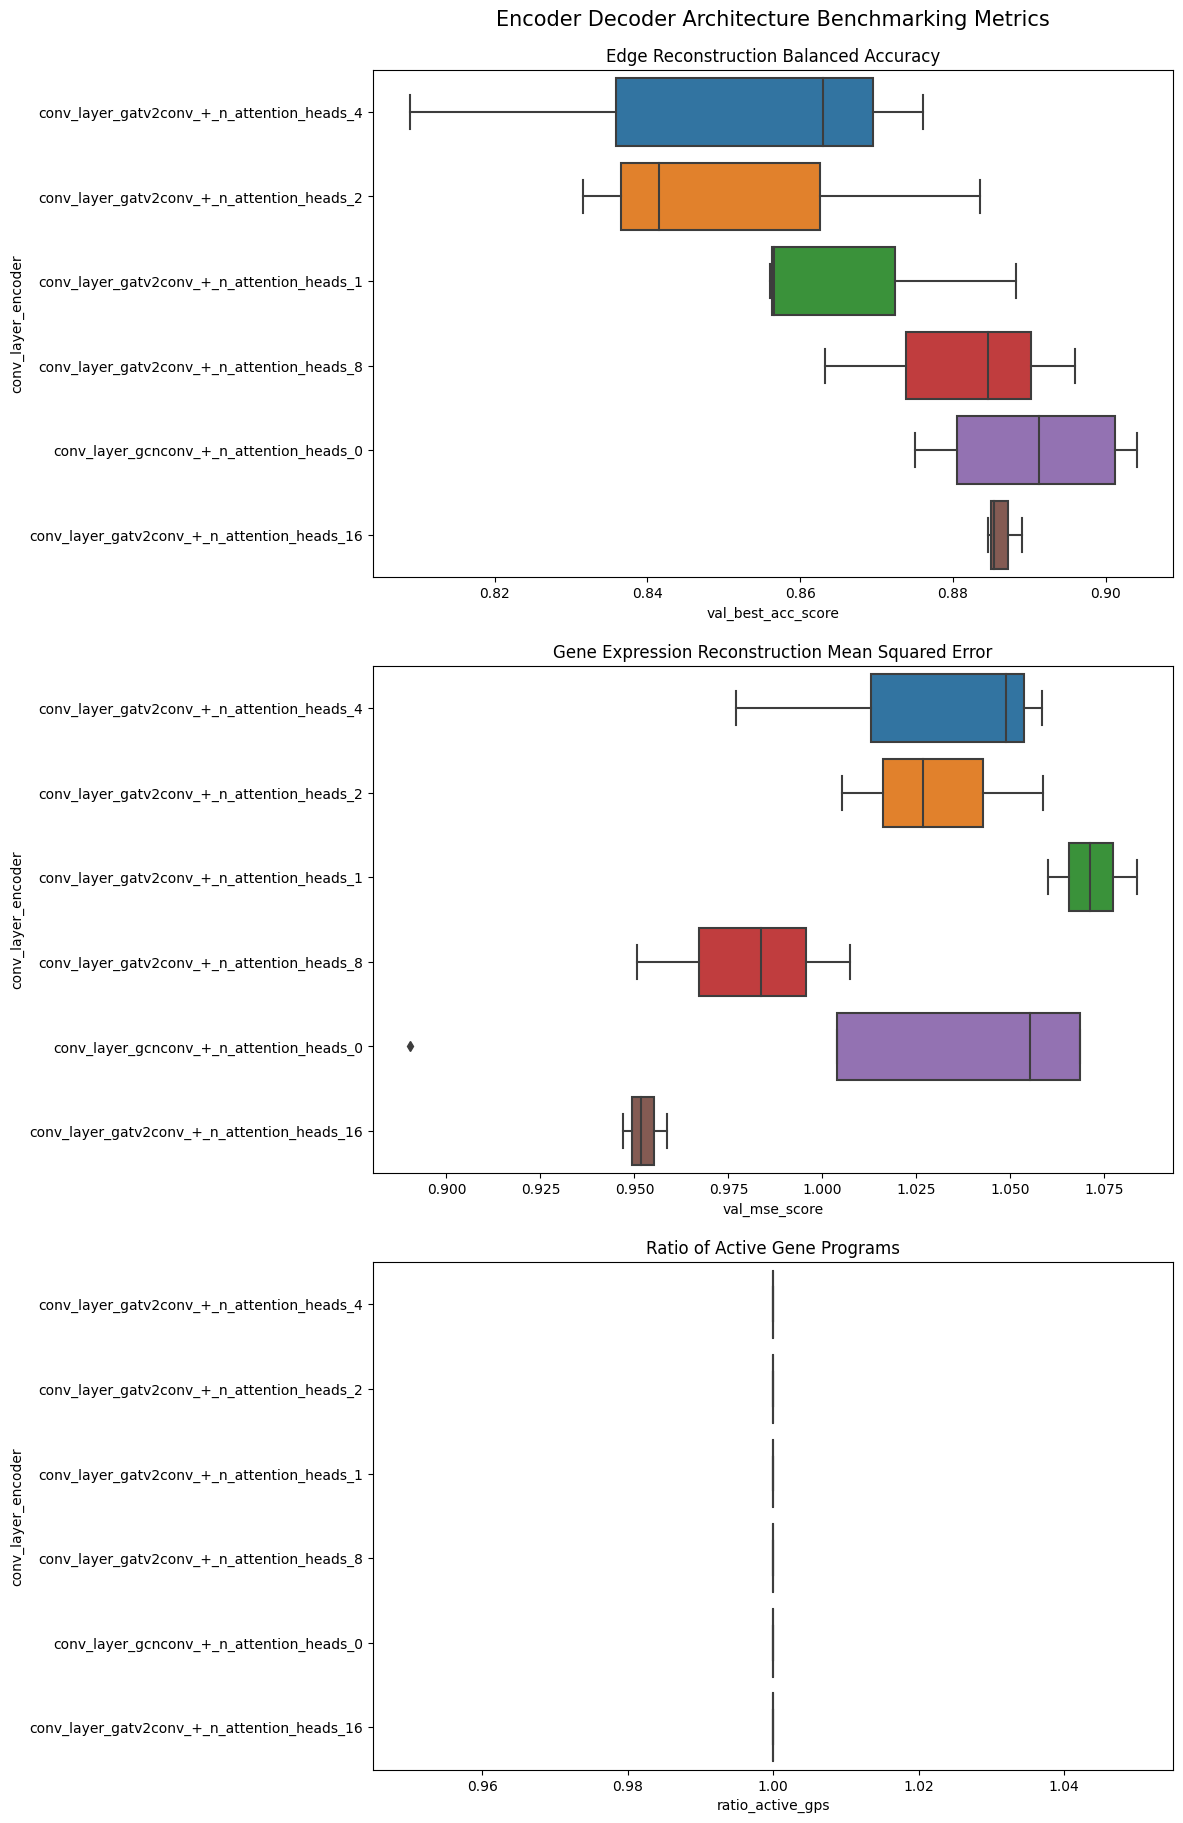

In [7]:
plot_eval_metrics(fig_title="Encoder Decoder Architecture Benchmarking Metrics",
                  df=df,
                  y_col_name="conv_layer_encoder",
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_encoder_decoder_arch2",
                  file_name="eval_metrics.png",
                  save_fig=False)

In [47]:
df.columns

Index(['val_mse_score', 'val_auroc_score', 'val_auprc_score',
       'val_best_acc_score', 'val_best_f1_score', 'n_active_gps', 'dataset',
       'n_nodes', 'n_genes', 'gp_mask', 'nichenet_keep_target_ratio',
       'omnipath_min_curation_effort', 'gp_filter_mode', 'combine_overlap_gps',
       'overlap_thresh_source_genes', 'overlap_thresh_target_genes',
       'overlap_thresh_genes', 'min_genes_per_gp', 'min_source_genes_per_gp',
       'min_target_genes_per_gp', 'avg_n_neighbors', 'n_edges',
       'early_stopping_kwargs_', 'edge_batch_size_', 'edge_train_ratio_',
       'edge_val_ratio_', 'grad_clip_value_', 'lambda_edge_recon_',
       'lambda_gene_expr_recon_', 'lambda_group_lasso_', 'lambda_l1_addon_',
       'loaders_n_direct_neighbors_', 'loaders_n_hops_', 'lr_', 'monitor_',
       'n_epochs_', 'n_epochs_all_gps_', 'n_epochs_no_edge_recon_',
       'node_batch_size_', 'node_train_ratio_', 'node_val_ratio_',
       'reload_best_model_', 'seed_', 'use_early_stopping_', 'verbose_

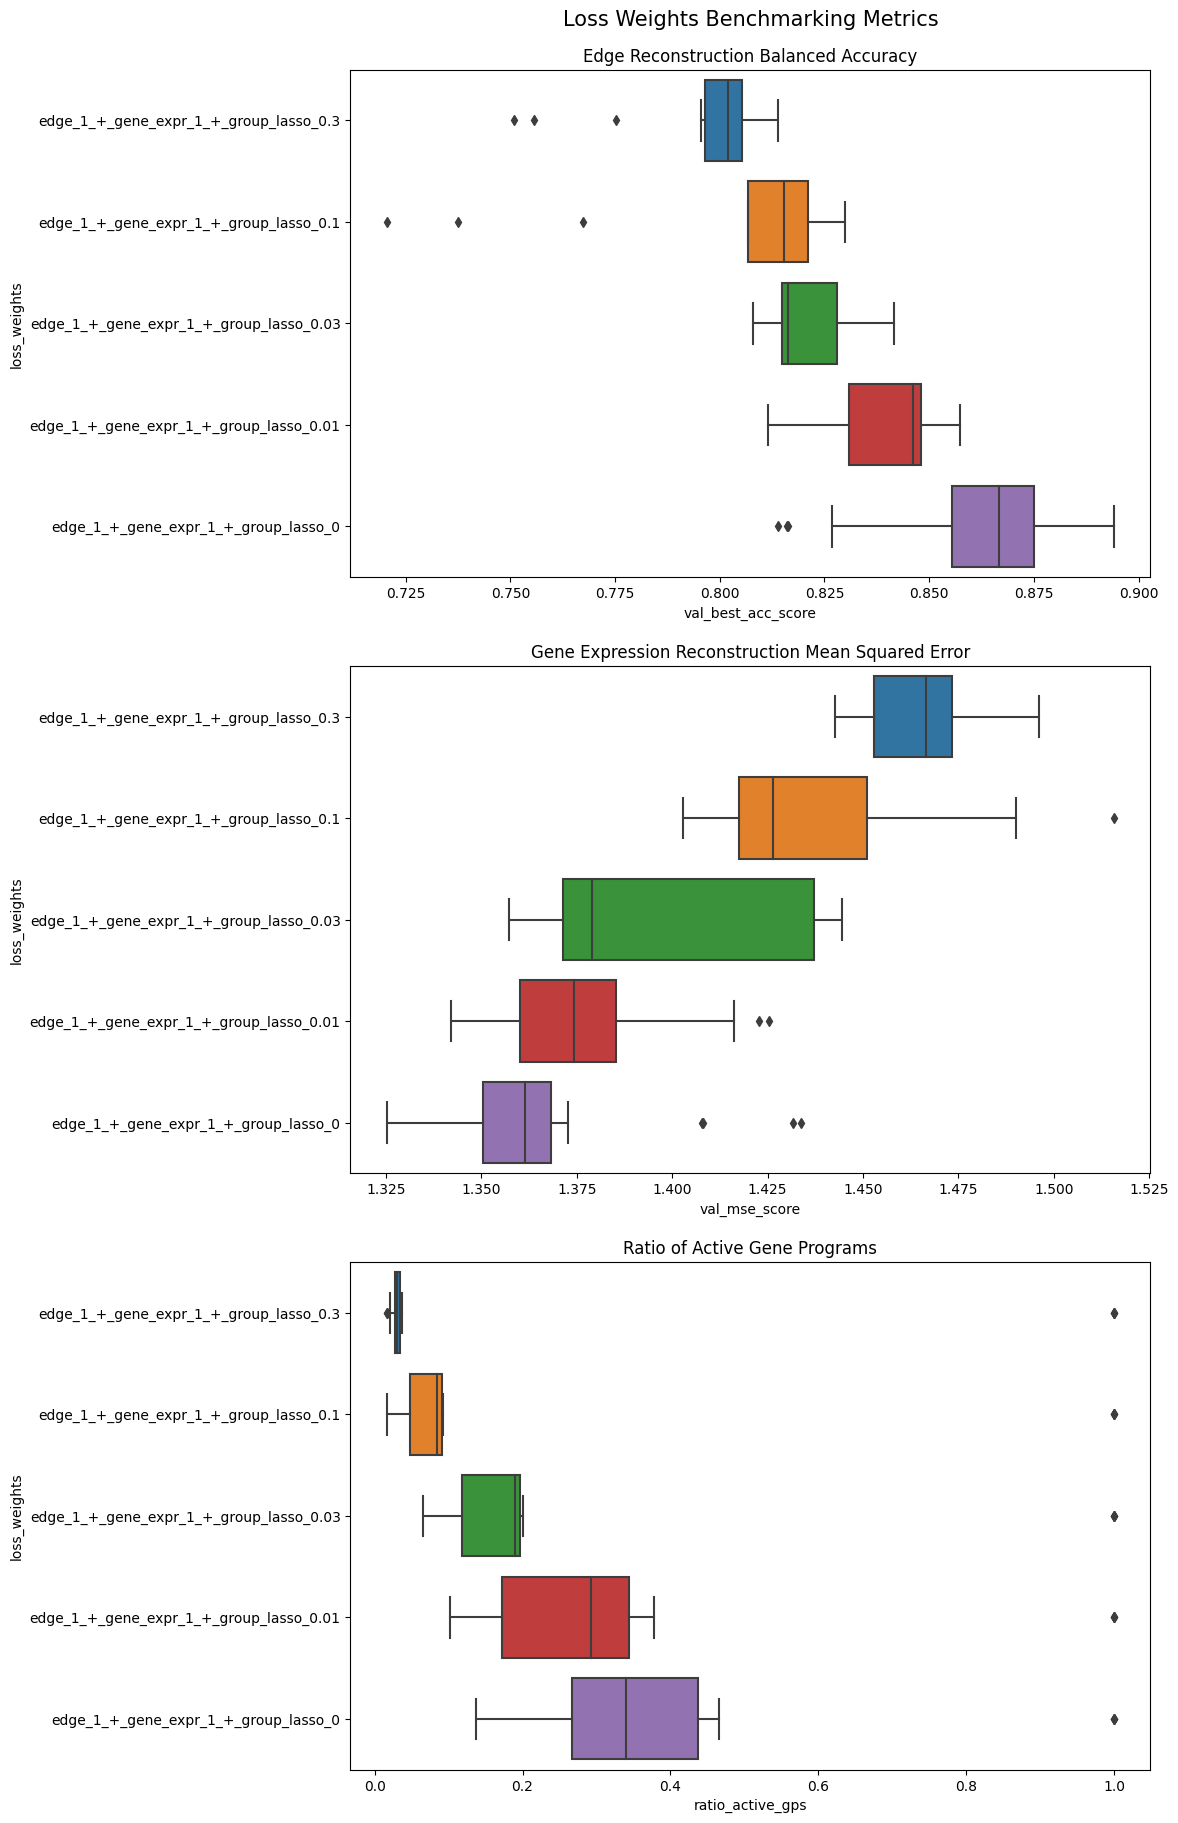

In [26]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="loss_weights",
                  save_fig=False)

In [ ]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="active_gp_group_lasso_comb",
                  save_fig=False)

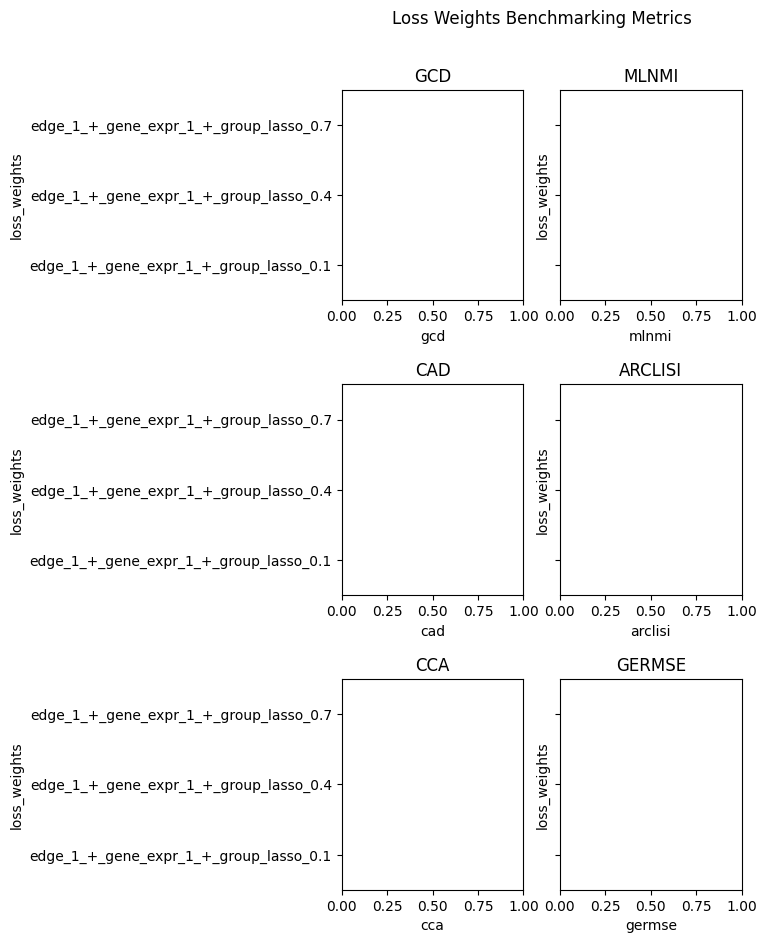

In [256]:
plot_benchmarking_metrics(fig_title="Loss Weights Benchmarking Metrics",
                          df=df,
                          y_col_name="loss_weights",
                          save_fig=False)

<AxesSubplot: xlabel='test_best_acc_score', ylabel='loss_weights'>

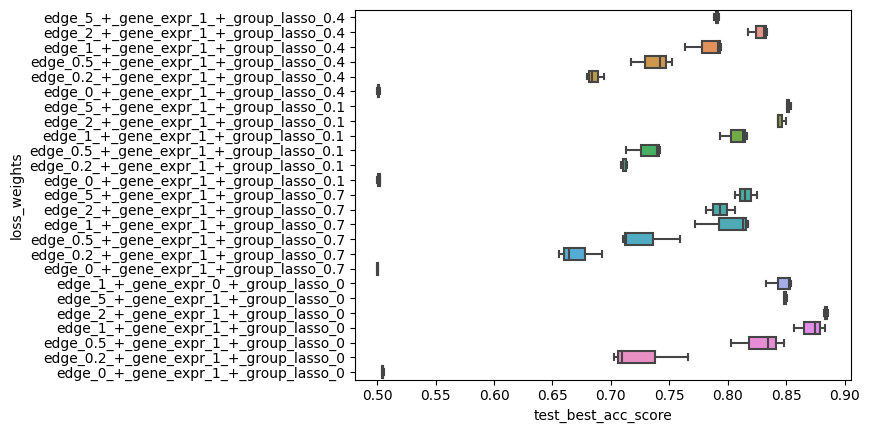

In [199]:
sns.boxplot(data=df, x="test_best_acc_score", y="loss_weights")

In [3]:
def get_recon_loss_inclusion(row):  
    if row["include_edge_recon_loss_"] == "True" and row["include_gene_expr_recon_loss_"] == "True":
        return "edge_+_gene_expr"
    elif row["include_edge_recon_loss_"] == "True" and row["include_gene_expr_recon_loss_"] == "False":
        return "only_edge"
    elif row["include_edge_recon_loss_"] == "False" and row["include_gene_expr_recon_loss_"] == "True":
        return "only_gene_expr"
    return "none"

df["recon_loss_inclusions"] = df.apply(lambda row: get_recon_loss_inclusion(row), axis=1)

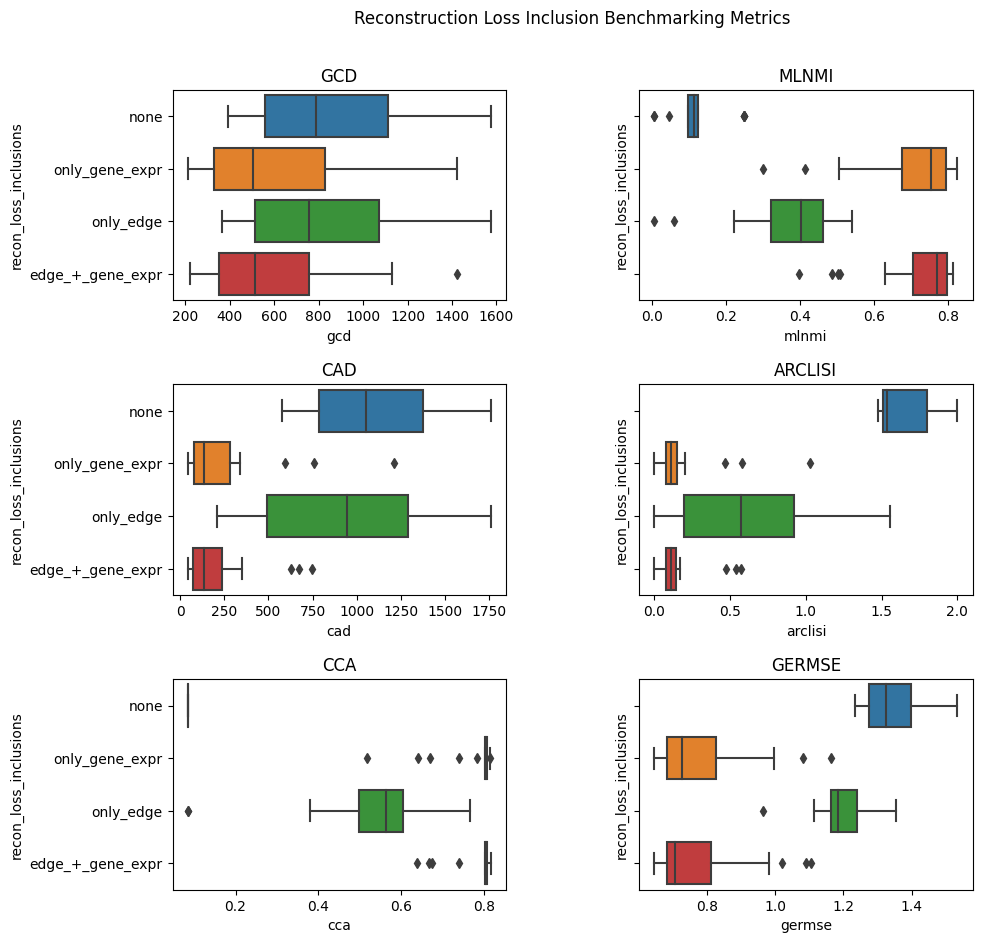

In [6]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Reconstruction Loss Inclusion Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="recon_loss_inclusions")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="recon_loss_inclusions")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="recon_loss_inclusions")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="recon_loss_inclusions")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="recon_loss_inclusions")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="recon_loss_inclusions")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [17]:
experiment_name = "benchmark_gene_expr_recon"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [18]:
def get_gene_expr_recon_components(row):  
    if row["node_label_method_"] == "self" and row["conv_layer_encoder_"] == "gcnconv":
        return "self_+_nb"
    elif row["node_label_method_"] == "self" and row["gene_expr_recon_dist_"] == "zinb":
        return "self_+_zinb"
    elif row["node_label_method_"] == "one-hop-sum" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-sum_+_nb"
    elif row["node_label_method_"] == "one-hop-sum" and row["gene_expr_recon_dist_"] == "zinb":
        return "one-hop-sum_+_zinb"
    elif row["node_label_method_"] == "one-hop-norm" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-norm_+_nb"
    elif row["node_label_method_"] == "one-hop-norm" and row["gene_expr_recon_dist_"] == "zinb":
        return "one-hop-norm_+_zinb"
    elif row["node_label_method_"] == "one-hop-attention" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-attention_+_nb"
    return "one-hop-attention_+_zinb"

df["gene_expr_recon_components"] = df.apply(lambda row: get_gene_expr_recon_components(row), axis=1)

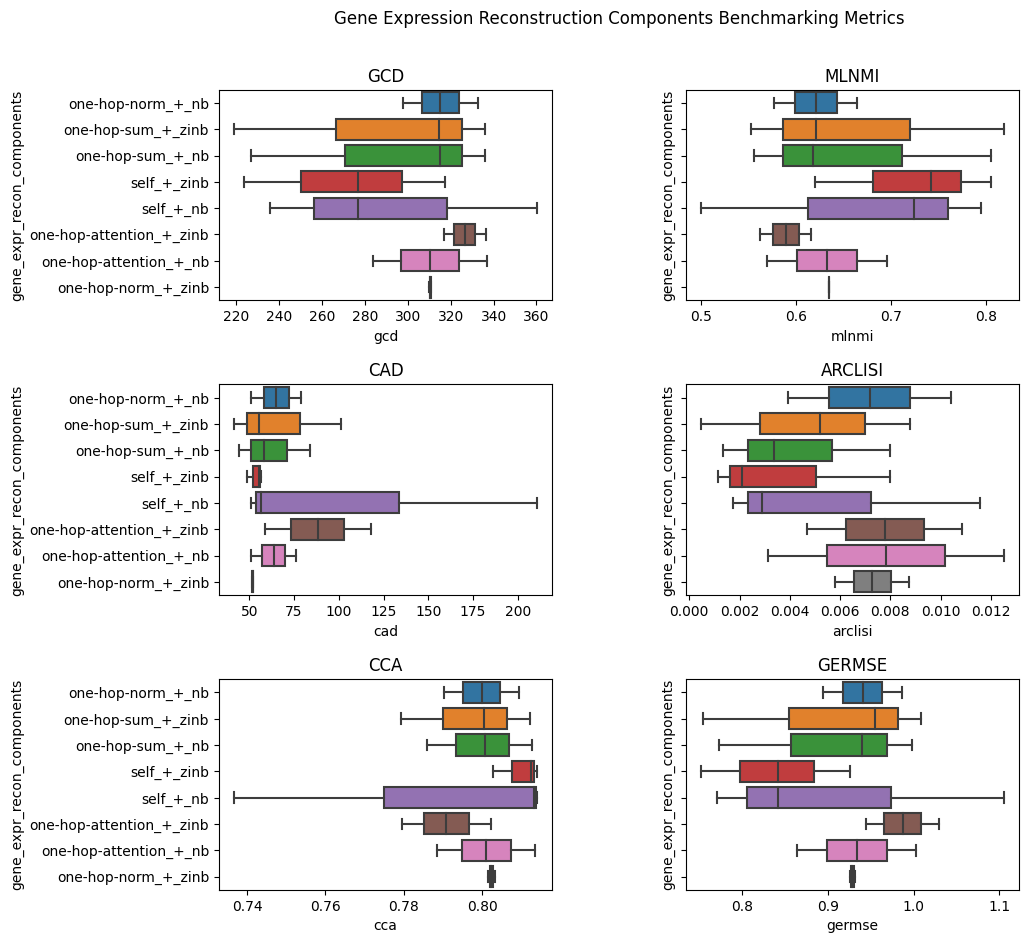

In [ ]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Gene Expression Reconstruction Components Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="gene_expr_recon_components")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="gene_expr_recon_components")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="gene_expr_recon_components")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="gene_expr_recon_components")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="gene_expr_recon_components")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="gene_expr_recon_components")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [45]:
def plot_benchmarking_metrics(fig_title,
                              df,
                              y_col_name,
                              save_fig=False,
                              save_dir="../figures",
                              file_name="benchmarking_metrics.png"):
    fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
    fig.suptitle(fig_title)
    
    # Graph Connectivity Distance
    sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y=y_col_name)
    axes[0, 0].set_title("GCD")

    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y=y_col_name)
    axes[0, 1].set_title("MLNMI")

    # Cell-Type Affinity Distance
    sns.boxplot(data=df, ax=axes[1, 0], x="cad", y=y_col_name)
    axes[1, 0].set_title("CAD")

    # Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
    sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y=y_col_name)
    axes[1, 1].set_title("ARCLISI")

    # Cell Classification Accuracy
    sns.boxplot(data=df, ax=axes[2, 0], x="cca", y=y_col_name)
    axes[2, 0].set_title("CCA")

    # Gene Expression Regression Mean Squared Error
    sns.boxplot(data=df, ax=axes[2, 1], x="germse", y=y_col_name)
    axes[2, 1].set_title("GERMSE")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.4)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}_{current_timestamp}.png",
                    bbox_inches='tight')

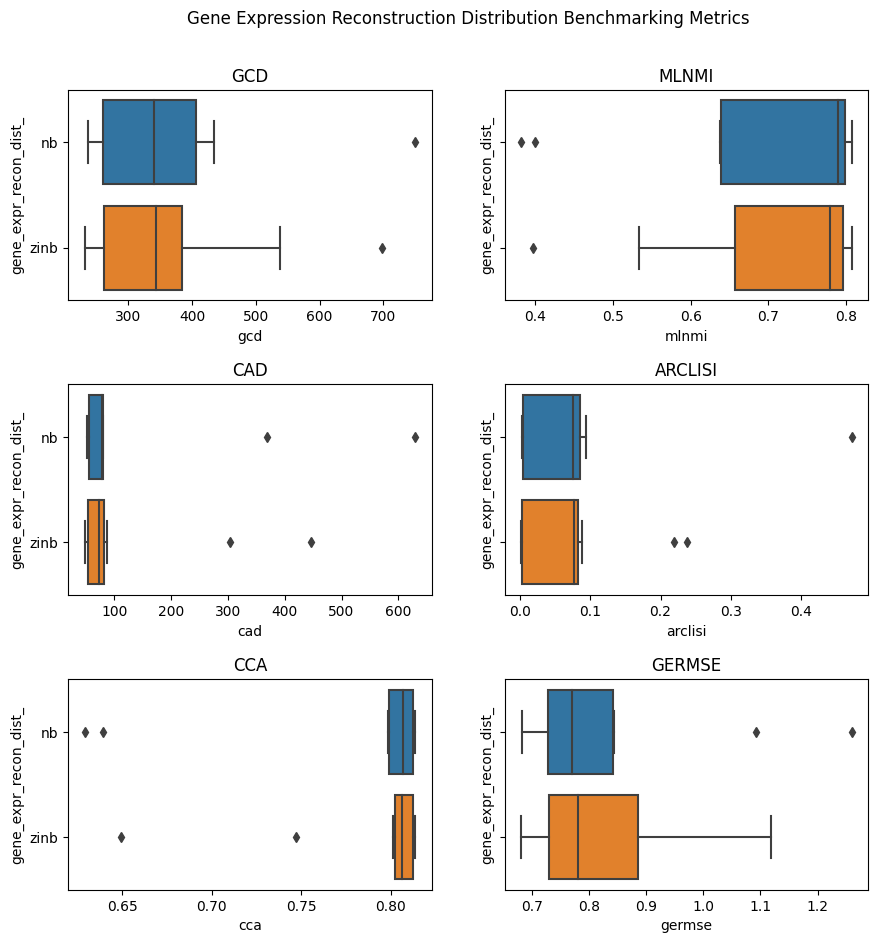

In [46]:
plot_benchmarking_metrics(fig_title="Gene Expression Reconstruction Distribution Benchmarking Metrics",
                          df=df,
                          y_col_name="gene_expr_recon_dist_",
                          save_fig=False)

In [22]:
experiment_name = "benchmark_conv_layer_encoder"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

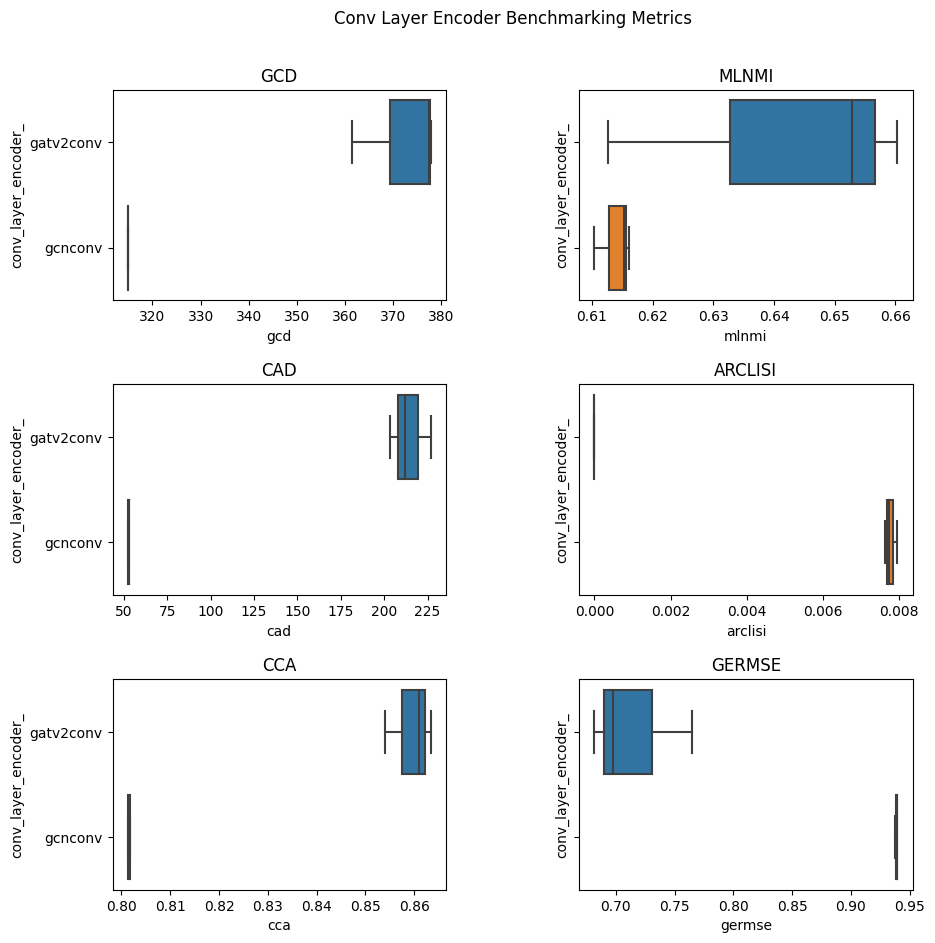

In [23]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Conv Layer Encoder Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="conv_layer_encoder_")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="conv_layer_encoder_")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="conv_layer_encoder_")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="conv_layer_encoder_")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="conv_layer_encoder_")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="conv_layer_encoder_")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)